In [9]:
import bz2
import json
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [47]:
# If working on colab :
from google.colab import drive
drive.mount('/content/drive') 

data_path = '/content/drive/MyDrive/'

In [10]:
# If working locally :
data_path = ''

# Initial methods given 

### Example of how to work with the quotes data file

In [13]:
from tld import get_tld

def get_domain(url):
    res = get_tld(url, as_object=True)
    return res.tld

In [ ]:
path_to_file = 'Quotebank/quotes-2020.json.bz2' 
path_to_out = '/data/quotes-2020-domains.json.bz2'

with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            instance = json.loads(instance) # loading a sample
            urls = instance['urls'] # extracting list of links
            domains = []
            for url in urls:
                tld = get_domain(url)
                domains.append(tld)
            instance['domains'] = domains # updating the sample with domain name
            d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

### Load the speaker_attributes parquet file

In [11]:
speaker_attributes = pd.read_parquet(data_path+'Project datasets/speaker_attributes.parquet')

In [12]:
speaker_attributes.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None
3,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,Q207,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
4,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Q297,Diego Velázquez,None,item,None


### Load the labels descriptions for quotebank

In [9]:
label_description = pd.read_csv(data_path+'Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [10]:
label_description.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


# Dealing with the features

For the questions we want to use, we don't need all the features. We decided to keep the following ones:


*   **date**: To be able to work with them.
*   **numOccurences**: To take out the duplicates.
*   **qids**: The speakers' id, necessary to connect with the speaker_attributes.
*   **quotation**: To be able to assess its positivity.
*   **quoteID**: To identify them.
*   **speaker**: To access their attributes and see if there's multiple qids for the same speaker.

For the 3 remaining features, we explain why we choosed to take them out:


#### phase

As we see on the [description of the phase](https://github.com/epfl-dlab/Quotebank/blob/main/phases.md). All of quotations we will use (2015-2020) are from phase E as they are past June 2014. We check below:

In [24]:
count_E = 0
count_quote = 0
quotes = bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb')

for instance in quotes:
    quote = json.loads(instance) # loading a sample
    phase = quote['phase'] # extracting list of links
    if phase == 'E':
        count_E += 1
    count_quote+=1

In [25]:
print(f'We have {count_E*100/count_quote}% of quotes in phase E for 2020')

We have 100.0% of quotes in phase E for 2020


As expected, we don't have any other phase than phase 'E' in the dataset from 2020. We shouldn't have them for 2015-2019. With the test on 2020 and the description's informations, we decided that it safe to drop this feature.

#### probas

We only keep the main speaker, therefore the probabilities and name of the other speakers are not useful for us. We chose to rely on the decisions made by QuoteBanks in choosing the speaker, and only keep the main(s) one(s).

#### Urls

In our research, we don't specificaly look into the source of the quote, expect for the speaker. Therefore, we decided to drop the urls feature as it is irrevelant to our research.

### Dropping the unwanted features

We drop the unwanted features as explained before. We do this by keeping 

In [28]:
def drop_features(path_to_file, path_to_out, max_instances=-1):
    count = 0
    with bz2.open(path_to_file, 'rb') as s_file:
        with bz2.open(path_to_out, 'wb') as d_file:
            for instance in s_file:
                if count == max_instances:
                    return
                instance = json.loads(instance)  # loading a sample
                series = pd.Series(instance)
                instance = series[[
                    'quoteID',
                    'date',
                    'numOccurrences',
                    'qids',
                    'quotation',
                    'speaker',
                    ]].to_dict()
                d_file.write((json.dumps(instance) + '\n').encode('utf-8'))  # writing in the new file
                count += 1

We try it with the 100 first instances:

In [29]:
path_to_file = data_path+'Quotebank/quotes-2020.json.bz2'
path_to_out = data_path+'data/quotes-2020-dropped-features.json.bz2'

drop_features(path_to_file, path_to_out, 100)

dropped_features_df = pd.read_json(path_to_out, compression='bz2', lines=True)
dropped_features_df.head()

,quoteID,date,numOccurrences,qids,quotation,speaker
0,2020-01-28-000082,2020-01-28 08:04:05,1,[],[ D ] espite the efforts of the partners to cr...,None
1,2020-01-16-000088,2020-01-16 12:00:13,1,[Q367796],[ Department of Homeland Security ] was livid ...,Sue Myrick
2,2020-02-10-000142,2020-02-10 23:45:54,1,[],... He (Madhav) also disclosed that the illega...,None
3,2020-02-15-000053,2020-02-15 14:12:51,2,[],"... [ I ] f it gets to the floor,",None
4,2020-01-24-000168,2020-01-24 20:37:09,4,[Q20684375],[ I met them ] when they just turned 4 and 7. ...,Meghan King Edmonds


### Special case: when we need to have the speaker's information

For two of our questions, see the [readMe.md](https://), we want to access the speaker's attributes. If we don't have any informations concerning them, the quote becomes unseful for our research. 

In [43]:
quotes = bz2.open(data_path'Quotebank/quotes-2020.json.bz2', 'rb')
count_none = 0
for instance in quotes:
    quote = json.loads(instance)  # loading a sample
    speaker = quote['speaker']  # extracting list of links
    if speaker == 'None':
        count_none += 1
print(count_none)

1800844


In [44]:
print(f'We have {count_none*100/count_quote}% of None ')

We have 34.338097291059555% of None 


As we see, on the quotebank data of 2020 we already have ~34% of missing speaker, labelled as "None". Therefore, we remove them from all the informations and write them in a new Json file.

Why do we remove them? Because if we look at the exemple below, 

In [26]:
## Load a quote

We see that, it is ~73% sure of not knowing who is the right speaker. We could take the as speaker the 

```
['Prime Minister Netanyahu', '0.2445']
```
We have more chance of it being false as it has only ~24% of chances of being him. We prefer to take only the speakers with an high chance of being right. We do it in the below method:


In [27]:
def drop_unknown_speaker(path_to_file, path_to_out, max_instances=-1):
    count = 0
    with bz2.open(path_to_file, 'rb') as s_file:
        with bz2.open(path_to_out, 'wb') as d_file:
            for instance in s_file:
                if count == max_instances:
                    return
                instance = json.loads(instance)  # loading a sample
                speaker = instance['speaker']
                if speaker != 'None':
                    d_file.write((json.dumps(instance) + '\n').encode('utf-8'))  # writing in the new file
                count += 1

We check it with 100 000 instances (to fasten the test part):

In [ ]:
path_to_file = data_path+'Quotebank/quotes-2020.json.bz2'
path_to_out = data_path+'data/quotes-2020-dropped_unknown_speaker.json.bz2'

drop_unknown_speaker(path_to_file, path_to_out, 100000)

dropped_unknown_speaker_df = pd.read_json(path_to_out, compression='bz2', lines=True)

print(dropped_unknown_speaker_df.loc[dropped_unknown_speaker_df.speaker == 'None', 'speaker'].count())

As we see, we can safely see that we take out all the 'None' speaker from the data.

# Data analysis

## Dates

As we are interested in dates, we want to understand their distributions.
As the dates are in the format 'yyyy-mm-dd hh:mm:ss', we check that all the dates are well in 2020 by checking the first 4 characters. Doing so helps us to check if there's any date which is not correctly written or missing:

In [ ]:
quotes = bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb')
for instance in quotes:
    quote = json.loads(instance)  # loading a sample
    date = instance['date']  # extracting the date
    if date[:4] == '2020':
        count_2020 += 1

In [ ]:
print(f'There is {count_2020*100/count_quote}% of date starting with 2020')

So it is as guessed.

To see the distribution of quotes per day of the year, we define a function to change the date format 'yyyy-mm-dd' into an index of a table. To do so we use the library date time.

In [45]:
def get_day_of_year(date):
    date_time_obj = datetime.strptime(date[2:], '%y-%m-%d %H:%M:%S')
    d = date_time_obj.strftime('%-j')
    return d

In [ ]:
print(get_day_of_year("2020-12-30 12:26:24"))

Now we can look at the distribution of the dates:

In [46]:
def count_per_day(path_to_file, max_instances=-1):
    count_days = np.zeros(366)
    count = 0
    with bz2.open(path_to_file, 'rb') as s_file:
        for instance in s_file:
            if count == max_instances:
                break
            instance = json.loads(instance)  # loading a sample
            date = instance['date']  # extracting the date
            idx = int(get_day_of_year(date)) - 1
            count_days[idx] += 1
            count += 1
        return count_days

We check for the different years with a sample of 100000 quotes to have a proper representation.

In [ ]:
years = ['2015','2016','2017','2018','2019','2020']
day = np.arange(366)

(fig, axes) = plt.subplots(6, constrained_layout=True, figsize=(15, 15))
fig.suptitle('Count of quotes per day of the year', fontsize=16)

for (year, ax) in zip(years, axes):
    path_to_file = data_path+'Quotebank/quotes-{year}.json.bz2'.format(year=year)
    count_days = count_per_day(path_to_file, max_instances=100000)
    ax.plot(day, count_days)
    ax.set_title(year)
    ax.set_xlabel('day of the year')
    ax.set_ylabel('count')

plt.show()

Everytime we look at the dates, we have to be careful about the number of quotations per day. It could lead to wrong results if we want to look at the distribution of a type of quote over time. We see an evident weekly tendency and the quotes for the year 2020 stop at ~110 days. There's also some seemingly unexplicable drop in quotes.For example, the quotes from year 2016 do some strange time where the data is missing.

## NumOccurrences 

We want to grasp more how important is the numOccurrences feature. To do so, we want to see its distribution. Firs, to know how big it can get, we check for the maximum, we also check for the minimum to be sure we don't have any negative values:

We know have the range for the number of occurences and will see how they are distributed on an histogram:

In [ ]:
min = 0
max = 0
count = 0
with bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', "rb") as s_file:
    for instance in s_file:
        instance = json.loads(instance)  # loading a sample
        numOccurrences = instance["numOccurrences"]  # extracting the date
        if numOccurrences < min:
            min = numOccurrences
        if numOccurrences > max:
            max = numOccurrences
        count = 1

In [ ]:
print(f'the min is {min}')
print(f'the max is {max}')

the min is 0
the max is 9210


In [ ]:
count_Occurences = np.zeros((max + 1, ))

with bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb') as s_file:
    for instance in s_file:
        instance = json.loads(instance)  # loading a sample
        numOccurrences = instance['numOccurrences']  # extracting the date
        count_Occurences[numOccurrences] += 1

9210


Text(0.5, 1.0, 'Distribution of the number of occurences for the quotes from 2019')

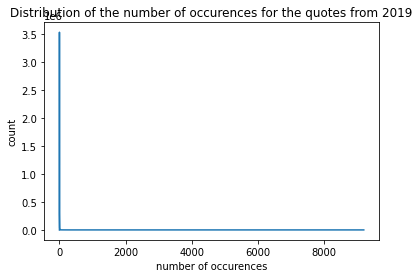

In [ ]:
occurences = np.arange(max+1)
print(max)
plt.plot(occurences, count_Occurences)
plt.xlabel("number of occurences")
plt.ylabel("count")
plt.title("Distribution of the number of occurences for the quotes from 2019")

As expected, most of the number of occurences are on the first number of occurences. Let's plot it on a logarithmic scale

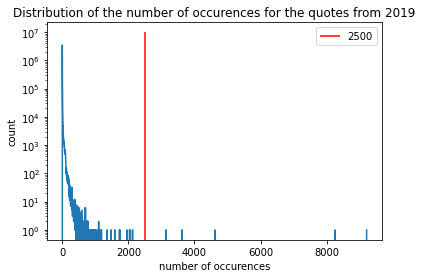

In [ ]:
occurences = np.arange(max+1)
plt.plot(occurences, count_Occurences)
plt.xlabel("number of occurences")
plt.ylabel("count")
plt.yscale('log')
plt.title("Distribution of the number of occurences for the quotes from 2019")
plt.vlines(2500, 0, 9999999, colors='r', label = '2500')
plt.legend()

We easily see the importance of the number of occurences from a quote. As expected most of them are quoted a relatively small amount of time. However, it has a possible importance in our research.

There is also some clear outliers. We will look at the number of occurences bigger than 2500 to see their number of occurences. We look at the ones bigger than one thousand because they are more rare and can be considered as outlier regarding the above distribution.

In [ ]:
enum = enumerate(count_Occurences)
dict_old = dict((i, j) for i,j in enum)

dict_new = { key: value for key, value in dict_old.items() if (key >2500 ) and (value > 0) }
print(dict_new)

{3133: 1.0, 3617: 1.0, 4624: 1.0, 8257: 1.0, 9210: 1.0}


As we see for each of these outlier, we have only one quote with a number of occurence this high. Let's look at them to see if there's anything strange about them:

In [ ]:
quotes_occurrences = []
with bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb') as s_file:
    for instance in s_file:
        instance = json.loads(instance)  # loading a sample
        numOccurrences = instance['numOccurrences']  # extracting the numOccurrences
        for num_occ in dict_new.keys():
            if numOccurrences == num_occ:
                quotes_occurrences.append(instance)

As we see, when a quote has an unusual number of occurences, it is likely that all the occurences come from the same site. If we take the example with the most occurences (9210), we easily see in the 'urls' that the occurences all seemingly come from the website gamereactor. We test it below:

In [106]:
quote = quotes_occurrences[2].get('quotation')
urls = quotes_occurrences[2].get('urls')
count = 0
count_gamereactor = 0
for url in urls:
    if url[11:22] == "gamereactor":
        count_gamereactor += 1
    count+=1

print(f'As we see there is {count_gamereactor*100/count}% of the occurences from the quote: <{quote}> comes from the website gamecore.')

As we see there is 100.0% of the occurences from the quote: <something we talk about a lot> comes from the website gamecore.


Seeing this, we still have to take into account this number of occurences but be extremly carefull with the extreme cases. If 9210 different people use the same quotation 1 time, it weighs more than 1 people using it 9210 time.

## Speakers

To have a better understanding of the speakers, we want to see the distribution of the speaker. If there's some speaker that take most of the place, it can mean an inbalance when we're using the speakers as group and we would have to be careful of this.

In [48]:
speakersID = set()
quotes = bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb')
for q in quotes:
    quote = json.loads(q)
    speakers = quote['qids']
    for speakerID in speakers:
        speakersID.add(speakerID)

In [49]:
len(speakersID)

323074

In [8]:
with bz2.open(data_path+'Quotebank/quotes-2020.json.bz2', 'rb') as s_file:
    for instance in s_file:
        instance = json.loads(instance)  # loading a sample
        speaker = instance['speaker']  # extracting the speaker
        if speaker != 'None':
            if speaker in dict_speaker.keys():
                dict_speaker[speaker] += 1
            else:
                dict_speaker.update({speaker: 1})

In [35]:
sorted_dict_speaker = {key: value for key, value in sorted(dict_speaker.items(), key=lambda item: item[1], reverse= True)}

place = 1
for (speak, nbr) in list(sorted_dict_speaker.items())[:10]:
    print(f'{place}: {speak} with {nbr} quotes')
    place += 1

1: President Donald Trump with 28023 quotes
2: Bernie Sanders with 13189 quotes
3: Joe Biden with 12817 quotes
4: President Trump with 12415 quotes
5: Andrew Cuomo with 11088 quotes
6: Narendra Modi with 8239 quotes
7: Elizabeth Warren with 7647 quotes
8: Donald Trump with 7104 quotes
9: Boris Johnson with 6952 quotes
10: Scott Morrison with 6601 quotes


Withtout surprise, it is important personalities that we find in the top 10 of our speaker for the year 2020. We mostly see political candidates. There's multiple information we see from this top 10:   

*   There's duplicate in our speakers: Donald trump under different name appears at 3 different places: 1st with 'President Donald Trump', 4th with 'President Trump' and 8th with 'Donald Trump'. However, if they are correctly classified in our research, it won't make any problem if it is Donald Trump or Joe biden that said the particular quotation: if we are looking at their job, they can be the same.
*   There's an obvious biais in the provenance of the quotation. 5 of the 8 most quoted people from the dataset are from the USAs: 

  *   Donald Trump: 45th U.S. President
  *   Bernie Sanders: United States Senator
  *   Joe Biden: 46th U.S. President
  *   Andrew Cuomo: Former Governor of New York
  *   Elizabeth Warren: United States Senator

  And only are from the rest of the world:

  *   Narendra Modi: Prime Minister of India
  *   Boris Jonhson: Prime Minister of the United Kingdom
  *   Scott Morrison: Prime Minister of Australia

  And all of them come from a political background. It means that when we are dealing with the 'speaker' feature, we have to be careful about the Data bias.






Below we look at the ~1% most quoted speakers. Then we look at the percentage of their combined number of quotes over the total number of quotes (minus the one without speakers, see the '_special case: when we need to have the speaker's information_' for the values _count_quote_ and _count_none_)

In [63]:
nbr_speakers = len(sorted_dict_speaker)
n = 2185 # Choice of n to make it the closest to 1%
print(f"Percentage of speaker: {n*100/nbr_speakers}")
sum = 0
for (k,v) in list(sorted_dict_speaker.items())[:n]:
    sum += v


print(f"Percentage of quotes:  {sum*100/(count_quote - count_none)}")

Percentage of speaker: 1.0003937476535387
Percentage of quotes:  32.43647282426411


We see that ~1% of the speakers were quoted for almost a third of the total number of quotations from recognized speaker. This add another Data bias to take into account.

# Preparing the data to pair speakers and their occupations

First let's create an array of all the different IDs for occupation and profession and removing duplicates and None values

In [52]:
work = set()
for w in speaker_attributes['occupation'].dropna():
    for i in w:
        work.add(i)
work = list(work)
len(work)

Now we will create a dictionnary which will have the QID as keys and the name and description of the job as values.

In [56]:
dwork = {}
for i in work:
    if i in label_description.index:
        dwork[i]=[label_description.loc[i]['Label'],label_description.loc[i]['Description']]
len(dwork)

As some QID had nan values we decided to count them to see how many there were and then we removed them as we couldn't use them.

In [58]:
summ=0
for i in dwork.values():
    if isinstance(i[0], float):
        summ+=1
        
print("There are",summ,"nan values.")

2460


In [59]:
dic_work={}
for i in dwork:
    if not isinstance(dwork[i], float):
        dic_work[i]=dwork[i]

len(dic_work)

12098

In [ ]:
dic_work['Q162555']

Now we have a new dataset that will help us regroup speaker regarding to their jobs

In [60]:
df_work = pd.DataFrame(dic_work.items(), columns=['ID', 'Label'])
df_work[['Label','Description']] = pd.DataFrame(df_work.Label.tolist(), index= df_work.index)
df_work.head()

Storing the new dataset in a parquet file

In [ ]:
df_work.to_parquet('data/Id_Work.parquet')

In [3]:
df = pd.read_parquet('data/Id_Work.parquet')
df.head()

,ID,Label
0,Q181217,Bey
1,Q11087077,Periodistas
2,Q10853156,alarife
3,Q678003,driving instructor
4,Q13141064,badminton player


### Clustering

We want to regroup the different occupations that are similar together, for example all the job realted to finance together, the one related to military together, medecine, law, etc...
As there are thousands of different occupations it can't reasonably be done manually so we are trying to group them using NLP and clustering. We don't have a proper model yet but we can already see that with Kmeans we already got clusters that make sens. There still are some problem like one cluster having too many unrelated value, which can be fixed by increasing the number of cluster as it acts like a "trash" for all the value that couldn't be clustered with others. But we also see that in the same cluster we would have for example dentist and oral surgeon but then also oral story telling, so we see that there still are flaws in our model. We will keep experimenting in order to get a realy good clustering model.

In [ ]:
df = df.dropna()
df.head()

In [ ]:
texts = df.Description # Extract text
target = df.Label # Extract target

Instead of just using the description we added the name of the occupation with it so that job with similar name would have a higher chance to be together

In [ ]:
job_desc = target.str.cat(texts, sep=' , ')
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(job_desc)

In [ ]:
number_of_clusters = 200

model = KMeans(n_clusters=number_of_clusters, 
               init='k-means++', 
               max_iter=100, # Maximum number of iterations of the k-means algorithm for a single run.
               n_init=1)  # Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia.

model.fit(X)

In [ ]:
lab = model.labels_
df_cluster = df.copy()
df_cluster['cluster'] = lab
df_cluster.head()

In [ ]:
df_cluster[df_cluster['cluster']==5].head()

In [ ]:
for i in range(number_of_clusters):
    print("cluster",i)
    print(len(df_cluster[df_cluster['cluster']==i]))

# First approach of the sentiment analysis 

## Polarity scores of quotes using Vader

In [66]:
sid = SentimentIntensityAnalyzer()

path_to_file = data_path+'Quotebank/quotes-2020.json.bz2' 
path_to_out = 'data/quotes-2020-polarity-scores.json.bz2'

with bz2.open(path_to_file, 'rb') as s_file:
    with bz2.open(path_to_out, 'wb') as d_file:
        for instance in s_file:
            instance = json.loads(instance)
            quote = instance['quotation']
            scores = sid.polarity_scores(quote)
            instance['polarity_scores'] = scores
            #print(scores)
            d_file.write((json.dumps(instance)+'\n').encode('utf-8')) # writing in the new file

{'neg': 0.0, 'neu': 0.79, 'pos': 0.21, 'compound': 0.872}
{'neg': 0.167, 'neu': 0.619, 'pos': 0.214, 'compound': 0.0}
{'neg': 0.113, 'neu': 0.84, 'pos': 0.046, 'compound': -0.4939}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 0.899, 'pos': 0.101, 'compound': 0.3041}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
{'neg': 0.038, 'neu': 0.888, 'pos': 0.074, 'compound': 0.3818}
{'neg': 0.121, 'neu': 0.715, 'pos': 0.165, 'compound': 0.2484}
{'neg': 0.0, 'neu': 0.691, 'pos': 0.309, 'compound': 0.8277}
